In [1]:
# http://51.195.220.149/book.php?id=964
# https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter3-autoencoders/autoencoder-2dim-mnist-3.2.2.py

In [2]:
'''Example of autoencoder model on MNIST dataset using 2dim latent
The autoencoder forces the encoder to discover 2-dim latent vector
that the decoder can recover the original input. The 2-dim latent
vector is projected on 2D space to analyze the distribution of code
in the latent space. The latent space can be navigated by varying the
values of latent vector to produce new MNIST digits.
This autoencoder has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
def plot_results(models,
                 data,
                 batch_size=32,
                 model_name="autoencoder_2dim"):
    """Plots 2-dim latent values as scatter plot of digits
        then, plot MNIST digits as function of 2-dim latent vector
    Arguments:
        models (list): encoder and decoder models
        data (list): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    xmin = ymin = -4
    xmax = ymax = +4
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "latent_2dim.png")
    # display a 2D plot of the digit classes in the latent space
    z = encoder.predict(x_test,
                        batch_size=batch_size)
    plt.figure(figsize=(12, 10))

    # axes x and y ranges
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])

    # subsample to reduce density of points on the plot
    z = z[0::2]
    y_test = y_test[0::2]
    plt.scatter(z[:, 0], z[:, 1], marker="")
    for i, digit in enumerate(y_test):
        axes.annotate(digit, (z[i, 0], z[i, 1]))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of the digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(xmin, xmax, n)
    grid_y = np.linspace(ymin, ymax, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = np.array([[xi, yi]])
            x_decoded = decoder.predict(z)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()



In [5]:
# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [7]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 2
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [8]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

In [9]:
# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which is processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

In [10]:
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [11]:
# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()
plot_model(encoder, to_file='encoder.png', show_shapes=True)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 2)                 6274      
                                                                 
Total params: 25,090
Trainable params: 25,090
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and instal

In [12]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [13]:
# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

In [14]:
# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [15]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289 

In [17]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 2)                 25090     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 90,179
Trainable params: 90,179
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [18]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

In [19]:
# train the autoencoder
autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=20,
                batch_size=batch_size)

Epoch 1/20
1875/1875 [==============================] - 8s 3ms/step - loss: 0.0544 - val_loss: 0.0478
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0464 - val_loss: 0.0453
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0445 - val_loss: 0.0444
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0436 - val_loss: 0.0436
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0429 - val_loss: 0.0433
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0425 - val_loss: 0.0428
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0421 - val_loss: 0.0423
Epoch 8/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0419 - val_loss: 0.0426
Epoch 9/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0416 - val_loss: 0.0421
Epoch 10/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.041

In [20]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test)

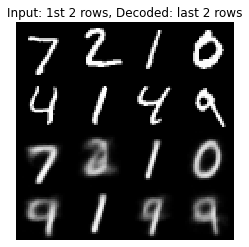

In [21]:
# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

In [ ]:
# project the 2-dim latent on 2D space
models = (encoder, decoder)
data = (x_test, y_test)
plot_results(models, data,
             batch_size=batch_size,
             model_name="autoencoder-2dim")